Project 1:
Chris Whitney 

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 


Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$


Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

 Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 


(Code Template Provided By Dr. Ren.)

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

logger = logging.getLogger(__name__)

Define our vatiables that will be used in the forward funtion to be evaulated. 

<br /><br />Here we investigate two parameters of the rockets landing. 

<br /><br />Vertical orientation - Distance from ground should when landing should be zero. 
    <br />Z+ Booster - possitive accleration 
    <br />Drag - possitive acceleration 
    <br />Gravity - negative acceleration 

<br /><br />Horizontal orientation - Horizontal positiononing on "ground target". X=0 Y=0 is the desired landing position 
    <br />X+ Booster - possitive accleration 
    <br />X- Bosster - negative acceleration 
    <br />Y+ Booster - possitive accleration
    <br />Y- Booster - negative acceleration 
    


In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
BOOST_ACCEL_X = 0.18  # thrust constant
BOOST_ACCEL_Y = 0.18  # thrust constant
BOOST_ACCEL_mX = -0.18  # thrust constant
BOOST_ACCEL_mY = -0.18  # thrust constant
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL_Z = 0.18  # thrust constant
drag = 0.02


Here we define our forward funtion which takes the follwoing inputs and outputs.  Here we define the actions as the booster onset and we define the states of the systems as the position and velocity of the rocket in the X, Y and Z directions. 

States (index):
<br />state [0] = x position
<br />state [1] = x velocity 
<br />state [2] = y position
<br />state [3] = y velocity
<br />state [4] = z position
<br />state [5] = z velocity  

Actions (index):
<br />action[0] =  X+ Booster
<br />action[1] =  X- Booster
<br />action[2] =  y+ Booster
<br />action[3] =  y- Booster
<br />action[4] =  z+ Booster

In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):


###Lateral Dynamics 
    #apply thrust in the positiven X direction in terms of an acceleartion constant and then multiply by a time step to calculate velocity
        xthrust_t=FRAME_TIME*t.tensor([0.,1.,0.,0.,0.,0.]) 
        xthrust_action=t.matmul(t.tensor([BOOST_ACCEL_X,0.,0.,0.,0.]), t.transpose(action,0,1))
        xthrust_t= t.transpose(xthrust_t.unsqueeze(0),0,1)
        xthrust=xthrust_t*xthrust_action
        xthrust=t.transpose(xthrust,0,1)

    #apply thrust in the negative X direction in terms of an acceleartion constant and then multiply by a time step to calculate velocity
        xmthrust_t=FRAME_TIME*t.tensor([0.,1.,0.,0.,0.,0.])
        xmthrust_action=t.matmul(t.tensor([0.,BOOST_ACCEL_mX,0.,0.,0.]), t.transpose(action,0,1))
        xmthrust_t= t.transpose(xmthrust_t.unsqueeze(0),0,1)
        xmthrust=xmthrust_action*xmthrust_t
        xmthrust=t.transpose(xmthrust,0,1)
    #apply thrust in the positiven Y direction in terms of an acceleartion constant and then multiply by a time step to calculate velocity     
        ythrust_t=FRAME_TIME*t.tensor([0.,0.,0.,1.,0.,0.])
        ythrust_action=t.matmul(t.tensor([0., 0.,BOOST_ACCEL_Y,0.,0.]), t.transpose(action,0,1))
        ythrust_t= t.transpose(ythrust_t.unsqueeze(0),0,1)
        ythrust=ythrust_action*ythrust_t
        ythrust=t.transpose(ythrust,0,1)

    #apply thrust in the negative Y direction in terms of an acceleartion constant and then multiply by a time step to calculate velocity
        ymthrust_t = FRAME_TIME*t.tensor([0.,0.,0.,1.,0.,0.])
        ymthrust_action = t.matmul(t.tensor([0., 0.,0.,BOOST_ACCEL_mY,0.]), t.transpose(action,0,1))
        ymthrust_t= t.transpose(ymthrust_t.unsqueeze(0),0,1)
        ymthrust=ymthrust_action*ymthrust_t
        ymthrust=t.transpose(ymthrust,0,1)
        
###Vertical Dynamics 
    #apply a graviational contant acting on the roacket in its descent and multiply by a time step to calculate velocity 
        delta_state_gravity = t.tensor([0.,0.,0.,0.,0.,GRAVITY_ACCEL * FRAME_TIME])
    #apply drag contant acting on the roacket in its descent and multiply by a time step to calculate velocity 
        delta_state_drag = t.tensor([0.,0.,0.,0.,0., -1 * drag * FRAME_TIME])

    #apply thrust in the Z direction in terms of an acceleartion constant and then multiply by a time step to calculate velocity   
        delta_state_t = FRAME_TIME*t.tensor([0.,0.,0.,0.,0.,-1.]) 
        delta_state_action =  t.matmul(t.tensor([0., 0.,0.,0.,BOOST_ACCEL_Z]), t.transpose(action,0,1))
        delta_state_t = t.transpose(delta_state_t.unsqueeze(0),0,1)
        delta_state =delta_state_action*delta_state_t
        delta_state=t.transpose(delta_state,0,1)

    # Update velocity
        state = state + xthrust + xmthrust + ythrust + ymthrust + delta_state + delta_state_gravity + delta_state_drag
        state = t.transpose(state,0,1)
        
       
    # Update state
        step_mat = t.tensor([[1., FRAME_TIME,0.,0., 0., 0.],
                            [0., 1.,0.,0.,0.,0.],
                             [0.,0.,1.,FRAME_TIME,0.,0.],
                             [0.,0.,0.,1.,0.,0.],
                             [0.,0.,0.,0.,1.,FRAME_TIME],
                             [0.,0.,0.,0.,0.,1.]])

        
        state = t.matmul(step_mat,state)
        state= t.transpose(state,0,1)
        
        return state

Here ourt contoller is defined as a sigmoind which acts on the action states of the system. 

In [4]:


class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            ##Hyperboblic Tangent 0,1
            nn.Tanh(),
            ##Linear 0,1
            nn.Linear(dim_hidden, dim_output),
            ##Weighter Sigmoid Linear Unit Layer - Decreased loss and increased convergnece weight 0,1 -- added layer
            #nn.SiLU(),
            ## Sigmoiud Function 0,1
            nn.Sigmoid() 
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [5]:

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

# Initilization state = [x position, x velocity, y position, y velocity, z position, z velocity]

    @staticmethod
    def initialize_state():

        max_x_pos=5
        max_y_pos=5
        max_z_pos=2

        max_x_vel=.2
        max_y_vel=.2
        max_z_vel=.1

        n=6 #random intial states
        
        state=np.zeros((n,6))
        for i in range(n):
            state[i-1,:] = [round(random.uniform(-max_x_pos, max_x_pos),2),round(random.uniform(0, max_x_vel),2),
            round(random.uniform(-max_y_pos, max_y_pos),2),round(random.uniform(0, max_y_vel),2),
            round(random.uniform(1, max_z_pos),2),-1*round(random.uniform(0, max_z_vel),2)]
        state=t.tensor(state)
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):


##Laplacian multipliers were investigated for convergence imrovement 
        l1=1
        l2=1
        l3=1
        l4=1
        l5=1
        l6=1

        return t.sum(l1*state[:,0]**2 + l2*state[:,1]**2 + l3*state[:,2]**2 + l4*state[:,3]**2 + l5*state[:,4]**2 + l6*state[:,5]**2)

In [6]:

losslist=[]
itterlist=[]

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()

        # Defineing the method for solving the optimization problem 
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        #self.optimizer = optim.SGD(self.parameters, lr=0.1, momentum=0.9)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.sum().backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            losslist.append(loss.detach())
            itterlist.append(epoch+1)
            #print('[%d] loss: %.3f' % (epoch + 1, loss))

            if (epoch == 0 or epoch == (epochs/2)-1 or epoch==epochs-1):
                self.visualize(epoch,loss)

    #Plotting the data code
    def visualize(self,epoch,loss):
        
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        maxrand=np.size(data, 1)
        n = random.randint(0,maxrand-1)

        Position_X = data[:,n, 0]
        Position_Y = data[:,n, 2]

        Velocity_X = data[:,n, 1]
        Velocity_Y = data[:,n, 3]

        Postion_Z = data[:,n, 4]
        Velocity_Z = data[:,n, 5]

        fig = plt.figure(figsize=(12, 12))
        fig.suptitle('Vissuliztion of solution at itteration [%d] \nloss=%.3f' % (epoch + 1, loss))
        gs = GridSpec(nrows=2, ncols=2)

        ax0 = fig.add_subplot(gs[0, 0])
        ax0.plot(Position_X, Position_Y)
        ax0.set_title('Horizonatal Positioning')
        ax0.set_ylabel('Position Y')
        ax0.set_xlabel('Position X')

        ax1 = fig.add_subplot(gs[1, 0])
        ax1.plot(Postion_Z, Velocity_Z)
        ax1.set_title('Vertical Positioning')
        ax1.set_ylabel('Velocity Z')
        ax1.set_xlabel('Position Z')
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.quiver(Position_X, Position_Y,Velocity_X,Velocity_Y,units='xy' ,scale=1)
        ax2.set_title('Horizontal Velocity Vector')
        ax2.set_ylabel('y velocity unit')
        ax2.set_xlabel('x velocity unit')

        ax3 = fig.add_subplot(gs[1, 1])
        ax3.plot(itterlist,losslist)
        ax3.set_title('loss vs. iteration')
        ax3.set_ylabel('loss')
        ax3.set_xlabel('itteration')
       

C:\Users\cwhit\AppData\Local\Temp/ipykernel_16528/2600527133.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t.tensor(state, requires_grad=False).float()


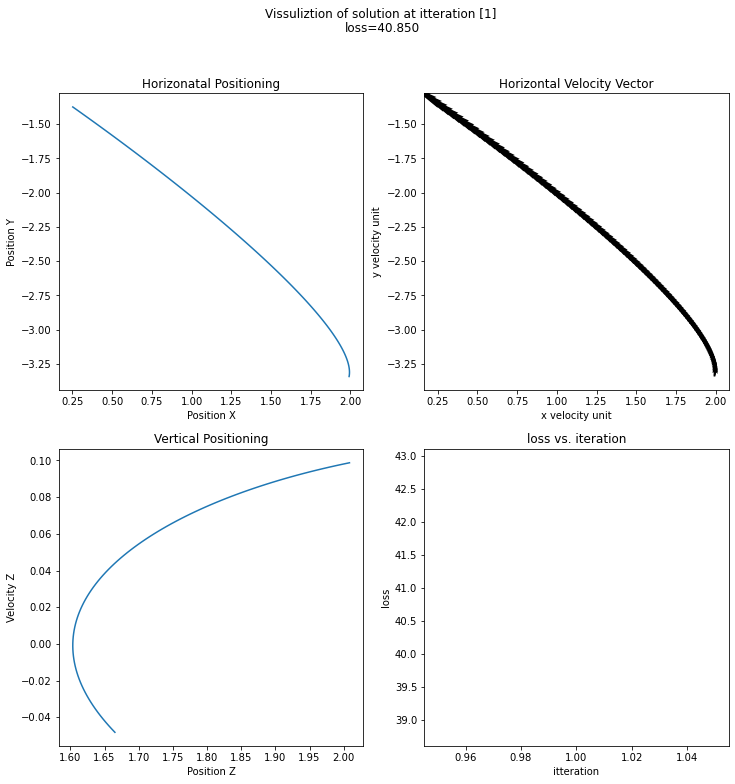

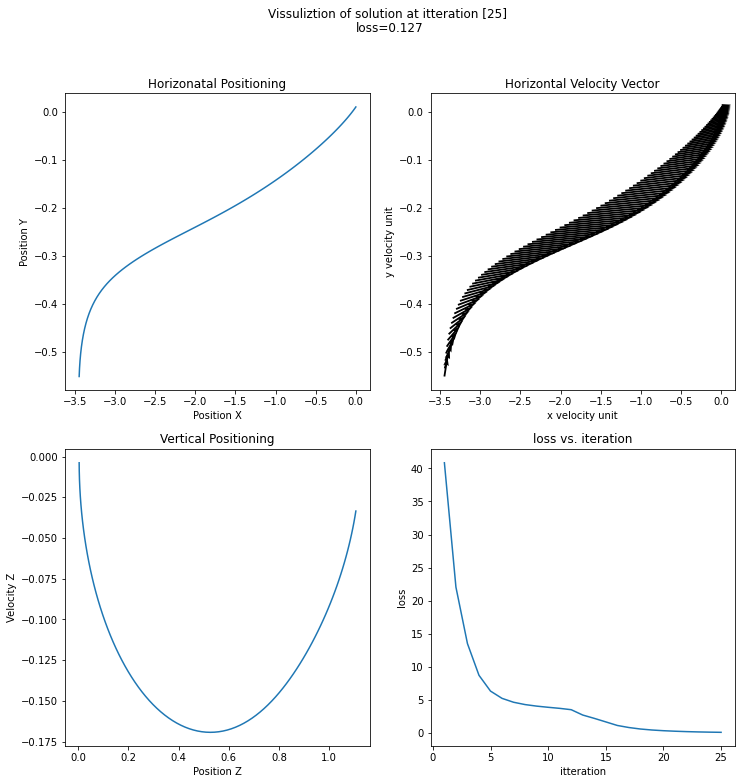

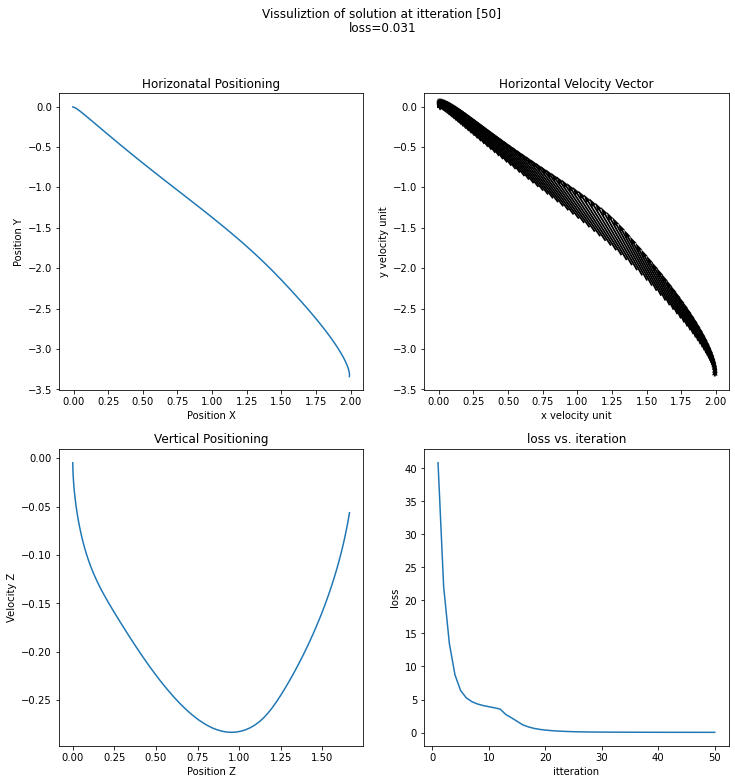

In [7]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6 # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 5  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

Analysis
<br />Here we look at optimizing the descent and landing of a rocket. Given a set of initial conditions we improve the dynamical model to further improve controller performance and we visualize the results <br />for investigation.
<br /><br />Initialization:
<br />The solver is given an initialization batch of size 1. The initialization criteria as following and represent an arbitrary unit.
<br />[x position=3, x velocity=.1, y position-1.5, y velocity=-.15, z position=1, z velocity=0]
<br />Initial conditions are chose randomly for 'n' number of batch batches and evaluated in parallel to improve optimization  
<br /><br />Dynamics:
<br />System dynamics include lateral and vertical thrust vectors on the principal x, y and z axis. Moreover, gravitational acceleration and vertical drag force are accounted for. The principal <br />physics that define our system states are F=ma and corresponding Newtonian equations of motion. 
<br /><br />Controller:
<br />The controller acts on the thrusters to adjust the positioning of the rocket to achieve final positioning of x=0, y=0 and z=0.  Additional constraints can be modified to adjust positioning of <br />the rocket on the principal axis.  The controller is currently set as multilayer function with sigmoid output existing between 0 and 1 with a sharp ramp between the two values. 
<br /><br />Plotted results:
<br />Four characteristic plots are generated [lateral positioning, lateral velocity vector, vertical height v. vertical velocity and loss vs. iteration].  The initial, middle, and final iteration of <br />the solver displays the plot to visualize convergence throughout the solution and the result are analyzed.
<br />From investigation and with consideration the expected behavior of a landing rocket we can asses that our dynamics behave as expected and converge to a location of [x,y,x]=[0,0,0]. 
<br /><br />With respect to the lateral positioning:
<br />We initialize a state with x and y not equal to zero and with velocity x and velocity y not equal to zero.  We see this behavior mirrored in the position and velocity plots. Moreover, as the <br />system iterated, we notice that the curvature of the position track become tighter and more optimized. Additionally, when looking at the velocity vector we notice similar behavior. 
<br /><br />With respect to vertical positioning:
<br />We initialize a position not equal to zero and the initialization velocity is equal to 0.  The effects of gravity act on the rock propelling it downward and the booter and drag resist the 
<br />gravitational acceleration. By inspection of the position velocity graph we see that the velocity and position converge to 0 which represent the rocket landing at h=0 velocity=0. 
<br /><br />Future Work:
<br />The system dynamic is not complete and should include at the very least roll, pitch, weight and other dynamic factors. Furthermore, external factors such as winds nonlinear drag forces as well <br />as other factors should be included the controller optimization. Batched initial conditions should be implemented and computational error should be accounted for. 

<br /><br />Conclusion:
<br />The model behaves as expected on converges to a value of 0. Multiple parameters we investigated to improve code performance which include:
<br /><br />controller depth (i.e. Linear weighted sigmoid function, Gaussian error linear units function and others.).
<br /><br />LaGrange multipliers were added to the loss function components to improve convergence for some controller configurations 
<br /><br />Initial conditions we controlled within reasonable expect values. 
<br /><br />Improved system dynamics.
<br /><br />From experience it was noticed that the initial conditions of the system should exist with a reasonable range as to not have a solution that diverges due the the Newtonian equations of motion. <br />(i.e. don’t have a lateral initialization velocity that cannot be overcome by the controller inputs). 